In [10]:
from gamesopt.train_distributed import train, TrainDistributedConfig
from gamesopt.games import GameOptions, QuadraticGameConfig, GameType
from gamesopt.optimizer import OptimizerOptions, OptimizerType
from gamesopt.aggregator import AggregationOptions, AggregatorType
from gamesopt.attacks import AttackOptions, AttackType
import matplotlib.pyplot as plt

%matplotlib widget
%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import torch, numpy, random

In [26]:
l1=torch.tensor([9,1,3,4,5])
l2=torch.tensor([1,1,3,2,5])
l3=torch.tensor([8,1,3,4,5])
l4=torch.tensor([4,1,0,4,5])
l5=torch.tensor([1,7,3,4,5])
l6=torch.tensor([2,6,3,5,4])
inputs=[l1,l2,l3,l4,l5,l6]
epsilon = 0.2
Z1_size = int(0.5*len(inputs))
Z_1 = random.sample(inputs,Z1_size)
Z_2 = list(set(inputs) - set(Z_1))
Z_1 = torch.stack(Z_1)
Z_2 = torch.stack(Z_2)
print(Z_1,Z_2,l1)
GAMMA=[]
BETA=[]
for i in range(1,Z_1.size()[1]+1):
    z = Z_1[i:]
    z = torch.sort(z).values
    print(z)
    gamma = torch.quantile(z, epsilon)
    beta = torch.quantile(z, 1-epsilon)
    GAMMA.append(gamma)
    BETA.append(beta)
# print(GAMMA,BETA)
T=[]
for z2 in Z_2:
    t=[]
    for j in range(Z_2.size()[1]):    
        if z2[j]>BETA[j]:
            t.append(BETA[j])
        elif z2[j]<GAMMA[j]:
            t.append(GAMMA[j])
        else:
            t.append(z2[j])
    T.append(t)
# print(numpy.array(T).shape,len(T), Z_2.shape, Z_1.shape)
tmean = numpy.sum(T,axis=0)/ len(T)


tensor([[4, 1, 0, 4, 5],
        [8, 1, 3, 4, 5],
        [9, 1, 3, 4, 5]]) tensor([[1, 1, 3, 2, 5],
        [1, 7, 3, 4, 5],
        [2, 6, 3, 5, 4]]) tensor([9, 1, 3, 4, 5])
tensor([[0, 1, 4, 4, 5]])


RuntimeError: quantile() input tensor must be either float or double dtype

TrainDistributedConfig(game=GameOptions(game_type=<GameType.QUADRATIC: 'quadratic'>, quadratic_options=QuadraticGameConfig(num_samples=100, dim=4, num_players=2, bias=True, sigma=0.01, mu=0.01, ell=100.0, seed=0, matrix=None)), optimizer=OptimizerOptions(optimizer_type=<OptimizerType.SGDARA: 'SGDARA'>, lr=0.005, alpha=0.98, batch_size=10, aggregation_options=AggregationOptions(n_total=20, n_byzan=4, aggregator_type=<AggregatorType.UnivariateTM: 'UnivariateTM'>, use_bucketing=True, bucketing_s=2, clipping_tau=102, clipping_n_iter=1, trimmed_mean_b=10, krum_m=2, rfa_T=10, rfa_nu=0.1), attack_options=AttackOptions(n_total=20, n_byzan=4, n_attacking=9, attack_type=<AttackType.IPM: 'InnerProductManipulation'>, rn_sigma=10.0, ipm_epsilon=0.01, alie_z=None), sigmaC=100.0, lr_inner=0.004999500049995, lr_outer=0.00124987501249875), num_iter=150, n_process=20)


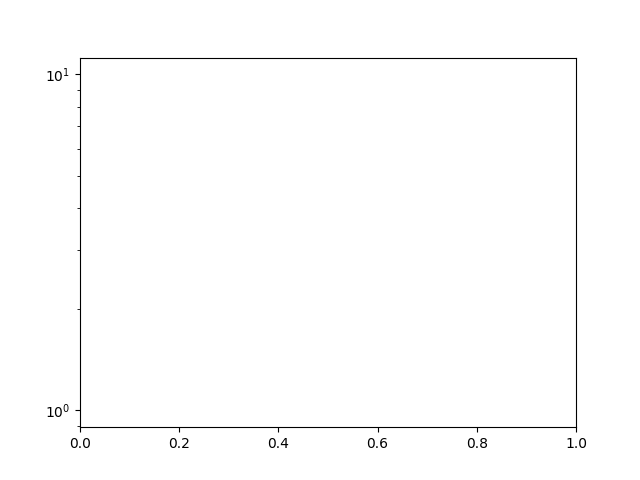

In [27]:
n_iter = 150

n_total = 20
n_byzan = 4

num_samples = 100
dim = 4
bias = True
sigma = 1e-2  # actually scales sigma
mu = 1e-2
ell = 1e2

attack_type = AttackType.IPM
n_attacking = 9
ipm_epsilon = 1e-2
rn_sigma = 10.


use_bucketing = True
bucketing_s = 2
aggregator_type = AggregatorType.UnivariateTM
trimmed_mean_b = 10
krum_m = 2
clipping_tau = 102
clipping_n_iter = 1
rfa_T: int = 10
rfa_nu: int = 0.1

optimizer_type = OptimizerType.SGDARA
# optimizer_type = OptimizerType.MSGDARA
# optimizer_type = OptimizerType.SEGDARA
alpha = 0.98
lr = 1/2/ell
lr_inner = 1/2/(ell+mu)
lr_outer = lr_inner/4
batch_size = 10
sigmaC = 100.

aggregation_options = AggregationOptions(n_total=n_total,
                                         n_byzan=n_byzan,
                                         aggregator_type=aggregator_type,
                                         use_bucketing=use_bucketing,
                                         bucketing_s=bucketing_s,
                                         trimmed_mean_b=trimmed_mean_b,
                                         krum_m=krum_m,
                                         clipping_tau=clipping_tau,
                                         clipping_n_iter=clipping_n_iter,
                                         rfa_T=rfa_T,
                                         rfa_nu=rfa_nu)

quadratic_game_options = QuadraticGameConfig(num_samples=num_samples,
                                             dim=dim,
                                             num_players=2,
                                             bias=bias,
                                             sigma=sigma,
                                             mu=mu,
                                             ell=ell)

game_options = GameOptions(GameType.QUADRATIC, quadratic_game_options)

attack_options = AttackOptions(n_total=n_total,
                               n_byzan=n_byzan,
                               n_attacking=n_attacking,
                               attack_type=attack_type,
                               ipm_epsilon=ipm_epsilon,
                               rn_sigma=rn_sigma)

optimizer_options = OptimizerOptions(optimizer_type=optimizer_type,
                                     lr=lr,
                                     batch_size=batch_size,
                                     aggregation_options=aggregation_options,
                                     attack_options=attack_options,
                                     sigmaC=sigmaC,
                                     alpha=alpha,
                                     lr_inner=lr_inner,
                                     lr_outer=lr_outer)

config = TrainDistributedConfig(game=game_options,
                                optimizer=optimizer_options,
                                num_iter=n_iter,
                                n_process=n_total)
print(config)
plt.figure()
plt.yscale('log')

In [23]:
config.optimizer.optimizer_type =  OptimizerType.SEGRA
config.optimizer.aggregation_options = AggregationOptions(n_total=n_total,
                                         n_byzan=n_byzan,
                                         aggregator_type=AggregatorType.UnivariateTM,
                                         use_bucketing=use_bucketing,
                                         bucketing_s=bucketing_s,
                                         trimmed_mean_b=trimmed_mean_b,
                                         krum_m=krum_m,
                                         clipping_tau=clipping_tau,
                                         clipping_n_iter=clipping_n_iter,
                                         rfa_T=rfa_T,
                                         rfa_nu=rfa_nu)
config.optimizer.aggregation_options.aggregator_type = AggregatorType.UnivariateTM
record = train(config)

record.load_metrics()

plt.plot(record.metrics.num_grad, record.metrics.dist,
        label="%s lr=%.e" % ('RDEG',
                                config.optimizer.lr))

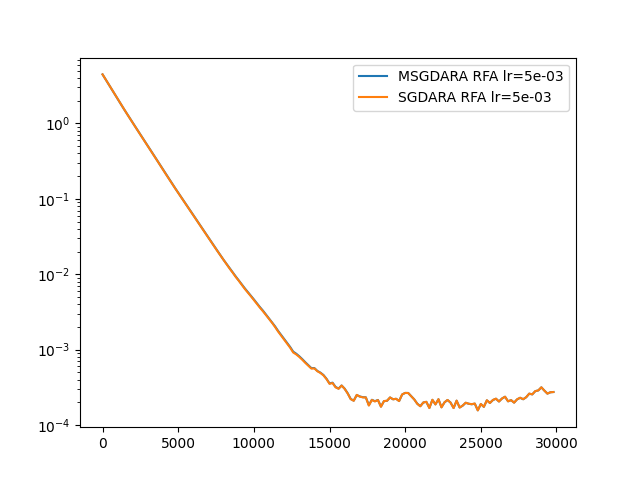

In [19]:
plt.legend()
plt.show()

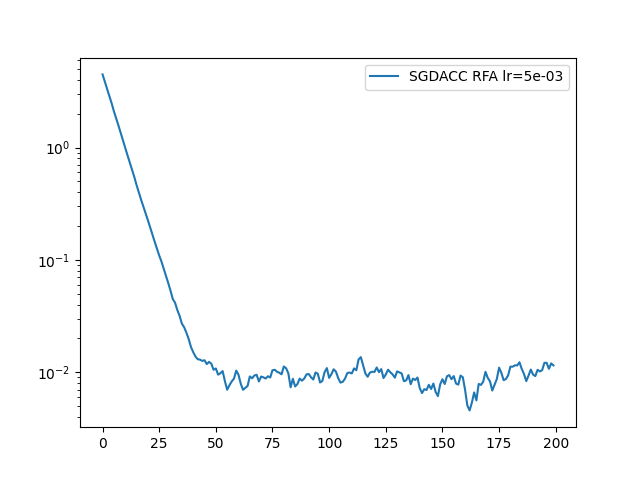

In [ ]:
plt.figure()
plt.yscale('log')
record.load_metrics()
# plt.figure()
plt.plot(record.metrics.n_iter, record.metrics.dist,
         label="%s %s lr=%.e" % (config.optimizer.optimizer_type.value,
                                 config.optimizer.aggregation_options.aggregator_type.value,
                                 config.optimizer.lr))
plt.yscale('log')
plt.legend()
plt.show()

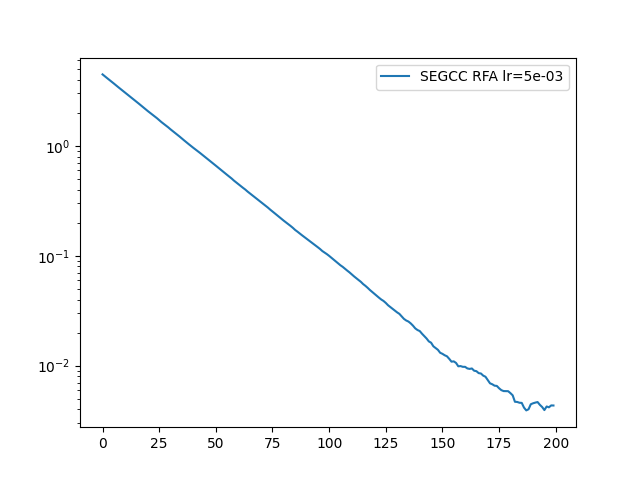

In [ ]:
plt.figure()
plt.yscale('log')
record.load_metrics()
# plt.figure()
plt.plot(record.metrics.n_iter, record.metrics.dist,
         label="%s %s lr=%.e" % (config.optimizer.optimizer_type.value,
                                 config.optimizer.aggregation_options.aggregator_type.value,
                                 config.optimizer.lr))
plt.yscale('log')
plt.legend()
plt.show()

Trying port 18391
Matrix generated
Bias generated
Solution found
Trying port 24794
Matrix generated
Bias generated
Solution found
Trying port 30793
Matrix generated
Bias generated
Solution found


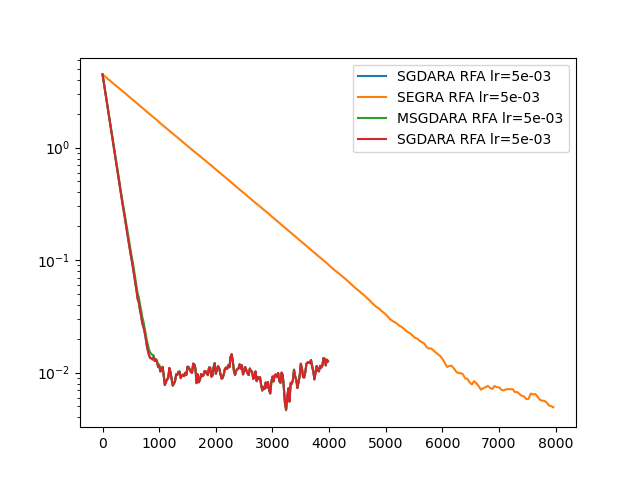

In [ ]:
for o_t in [OptimizerType.SEGRA, OptimizerType.MSGDARA, OptimizerType.SGDARA]:
    config.optimizer.optimizer_type = o_t
    record = train(config)

    plt.yscale('log')
    record.load_metrics()
    # plt.figure()
    plt.plot(record.metrics.num_grad, record.metrics.dist,
            label="%s %s lr=%.e" % (config.optimizer.optimizer_type.value,
                                    config.optimizer.aggregation_options.aggregator_type.value,
                                    config.optimizer.lr))
    plt.yscale('log')
    plt.legend()
plt.show()